# Data Cleaning and Visualization of movie data to Recommend a Movie for Microsoft Studios to Produce

## Andre's code:

Import needed modules for the code to run.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics
import numpy as np
import sqlite3
import matplotlib.ticker as ticker

Access the data and assign each file to a dataframe. For SQL database, pull the tables that could be useful. 

In [2]:
movies = pd.read_csv("data/tmdb.movies.csv")

In [3]:
budgets = pd.read_csv("data/tn.movie_budgets.csv")

In [4]:
reviews = pd.read_csv("data/rt.reviews.tsv", sep="\t", header=0, encoding="ISO-8859-1")

In [5]:
info = pd.read_csv("data/rt.movie_info.tsv", delimiter = "\t")

In [6]:
conn = sqlite3.connect("data/im.db")

df = pd.read_sql_query("""

SELECT * 
FROM "sqlite_master"

""", conn)

In [7]:
gross = pd.read_csv("data/bom.movie_gross.csv")

In [8]:
movie_basics = pd.read_sql_query("""

SELECT * 
FROM "movie_basics"

""", conn)

In [9]:
directors = pd.read_sql_query("""

SELECT * 
FROM "directors"

""", conn)

In [10]:
known_for = pd.read_sql_query("""

SELECT * 
FROM "known_for"

""", conn)

In [11]:
movie_akas = pd.read_sql_query("""

SELECT * 
FROM "movie_akas"

""", conn)

In [12]:
movie_ratings = pd.read_sql_query("""

SELECT * 
FROM "movie_ratings"

""", conn)

In [13]:
persons = pd.read_sql_query("""

SELECT * 
FROM "persons"

""", conn)

In [14]:
principals = pd.read_sql_query("""

SELECT * 
FROM "principals"

""", conn)

In [15]:
writers = pd.read_sql_query("""

SELECT * 
FROM "writers"

""", conn)

In [16]:
# Merge the budgets and gross dfs by movie to get info into one table
money_df = budgets.merge(gross, left_on="movie",right_on="title", how="inner")

In [17]:
# Merge the money_df into movies once again on movie titles
mov_mon_df = movies.merge(money_df, left_on="title",right_on="movie", how="inner")

In [18]:
# Fixing the object in foreign_gross by making it into numerics
mov_mon_df["foreign_gross"] = pd.to_numeric(mov_mon_df["foreign_gross"], errors='coerce')

In [19]:
# Adding a new column in the db which sums domestic and foriegn gross revenue
mov_mon_df["worldwide_gross_int"] = mov_mon_df["domestic_gross_y"] + mov_mon_df["foreign_gross"]

In [20]:
# Fixing the production budget column to be formatted in numerics
mov_mon_df["production_budget_clean"] = mov_mon_df["production_budget"].replace({"\$":"",",":""},regex=True)

mov_mon_df["production_budget_clean"] = pd.to_numeric(mov_mon_df["production_budget_clean"], errors='coerce')

In [21]:
# Merging the movie basics onto the existing df to make a new one
temp = mov_mon_df.merge(movie_basics, left_on="movie",right_on="primary_title", how="inner")

In [22]:
# Merging again to ensure that titles are all accounted for, including original and primary
mov_genres_money_df = temp.merge(movie_basics, left_on="movie",right_on="original_title", how="inner")

In [23]:
# Cleaning the db
mov_clean = mov_genres_money_df.drop_duplicates(subset="original_title")

In [24]:
# Grouping by genres
grouped = mov_clean.groupby("genres_y").sum()

Finding the highest grossing genres of movie

In [25]:
grouped.sort_values(by="worldwide_gross_int",ascending=False).head(5)

,Unnamed: 0,id_x,popularity,vote_average,vote_count,id_y,domestic_gross_y,foreign_gross,year,worldwide_gross_int,production_budget_clean,start_year_x,runtime_minutes_x,start_year_y,runtime_minutes_y
genres_y,,,,,,,,,,,,,,,
"Action,Adventure,Sci-Fi",460114,5517479,1013.059,268.4,318238,1951,9.825200e+09,1.479340e+10,82582,2.328750e+10,6941600000,82578,5367.0,82578,5367.0
"Adventure,Animation,Comedy",682524,10273253,860.162,356.7,144127,2539,8.194900e+09,1.500050e+10,114809,2.316890e+10,5890500000,114808,5361.0,114808,5361.0
"Action,Adventure,Fantasy",408675,5514396,648.973,169.3,140475,1470,3.667600e+09,7.863200e+09,56425,1.153080e+10,4195600000,56422,3273.0,56422,3273.0
"Action,Adventure,Comedy",234595,3493874,416.397,102.1,114583,635,2.686100e+09,4.651500e+09,30232,7.337600e+09,1670000000,30230,1738.0,30230,1738.0
"Action,Adventure,Animation",126921,1974097,242.248,92.5,51850,625,2.156091e+09,4.082900e+09,26174,6.238991e+09,1690000000,26171,1300.0,26171,1300.0


In [26]:
# New df to see runtime vs revenue
run = mov_clean.groupby("runtime_minutes_y").sum().sort_values(by="worldwide_gross_int",ascending=False)

In [27]:
# Reset index
run = run.reset_index()

## Quick visualization of each runtime as an individual bucket on the x axis, mapped to the sum of revenue for each bucket

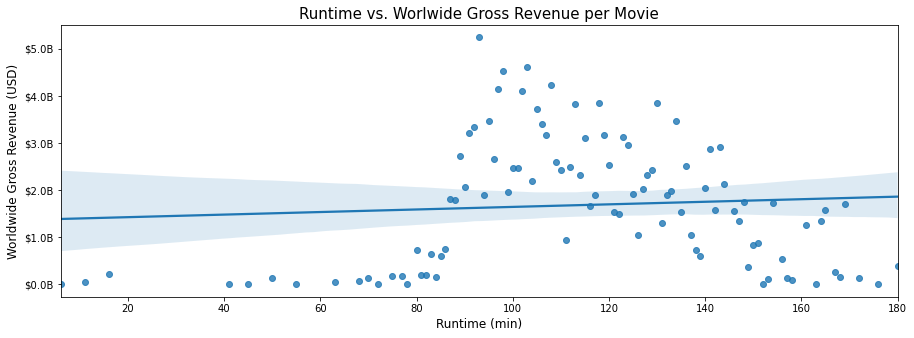

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.regplot(x=run["runtime_minutes_y"], y=run["worldwide_gross_int"],ax=ax)
ax.set_xlabel("Runtime (min)", size = 12 )
ax.set_ylabel("Worldwide Gross Revenue (USD)", size = 12)
ax.set_title("Runtime vs. Worlwide Gross Revenue per Movie", size = 15)
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fB' % (x * 1e-9))
ax.yaxis.set_major_formatter(formatter);

In [29]:
# Show the highest worldwide revenue grouped by genre
grouped.sort_values(by="worldwide_gross_int",ascending=False)

,Unnamed: 0,id_x,popularity,vote_average,vote_count,id_y,domestic_gross_y,foreign_gross,year,worldwide_gross_int,production_budget_clean,start_year_x,runtime_minutes_x,start_year_y,runtime_minutes_y
genres_y,,,,,,,,,,,,,,,
"Action,Adventure,Sci-Fi",460114,5517479,1013.059,268.4,318238,1951,9.825200e+09,1.479340e+10,82582,2.328750e+10,6941600000,82578,5367.0,82578,5367.0
"Adventure,Animation,Comedy",682524,10273253,860.162,356.7,144127,2539,8.194900e+09,1.500050e+10,114809,2.316890e+10,5890500000,114808,5361.0,114808,5361.0
"Action,Adventure,Fantasy",408675,5514396,648.973,169.3,140475,1470,3.667600e+09,7.863200e+09,56425,1.153080e+10,4195600000,56422,3273.0,56422,3273.0
"Action,Adventure,Comedy",234595,3493874,416.397,102.1,114583,635,2.686100e+09,4.651500e+09,30232,7.337600e+09,1670000000,30230,1738.0,30230,1738.0
"Action,Adventure,Animation",126921,1974097,242.248,92.5,51850,625,2.156091e+09,4.082900e+09,26174,6.238991e+09,1690000000,26171,1300.0,26171,1300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Drama,Family,Sport",11528,232679,6.080,6.6,185,50,3.010000e+07,0.000000e+00,2014,0.000000e+00,15000000,2014,115.0,2014,115.0
"Drama,Fantasy,Mystery",20718,397837,14.584,7.0,2135,12,1.220000e+07,0.000000e+00,2017,0.000000e+00,5000000,2017,98.0,2017,98.0
Family,21940,408616,1.893,6.7,20,59,1.550000e+05,0.000000e+00,2017,0.000000e+00,500000,2010,0.0,2010,0.0


In [30]:
# Reset index
grouped = grouped.reset_index()

In [31]:
# Clean grouped genres for use
grouped["genres_clean"] = grouped["genres_y"].str.split(",",0)
clean_list =[]
for i in grouped["genres_clean"]:
    clean_list.append(i[0])
    
grouped["genres_clean"] = clean_list

In [32]:
# Create new df to include runtime and genres clean and be grouped by both
run_genre = grouped.groupby(["runtime_minutes_y", "genres_clean"]).sum().sort_values(by="worldwide_gross_int",ascending=False)
run_genre.reset_index(inplace=True)

In [33]:
# Clean release date to extract months for use
months = []
for i in budgets["release_date"]:
    temp = []
    first = i.split(" ")
    temp.append(first[0])
    months.append(temp[0])

budgets["release_month"] = months

In [34]:
# Clean worldwide_gross to be numeric
budgets["worldwide_gross"] = budgets["worldwide_gross"].replace({"\$":"",",":""},regex=True)

budgets["worldwide_gross"] = pd.to_numeric(budgets["worldwide_gross"], errors='coerce')

In [35]:
# Group by month and display the sum of worldwide_gross in chart
month_by = budgets.groupby("release_month").sum().sort_values(by="worldwide_gross",ascending=False)
month_by.reset_index(inplace=True)

## Visual of Worldwide Gross Revenue by Release Month, showing that the best months are December, June, May, November, and July to release any movie. 

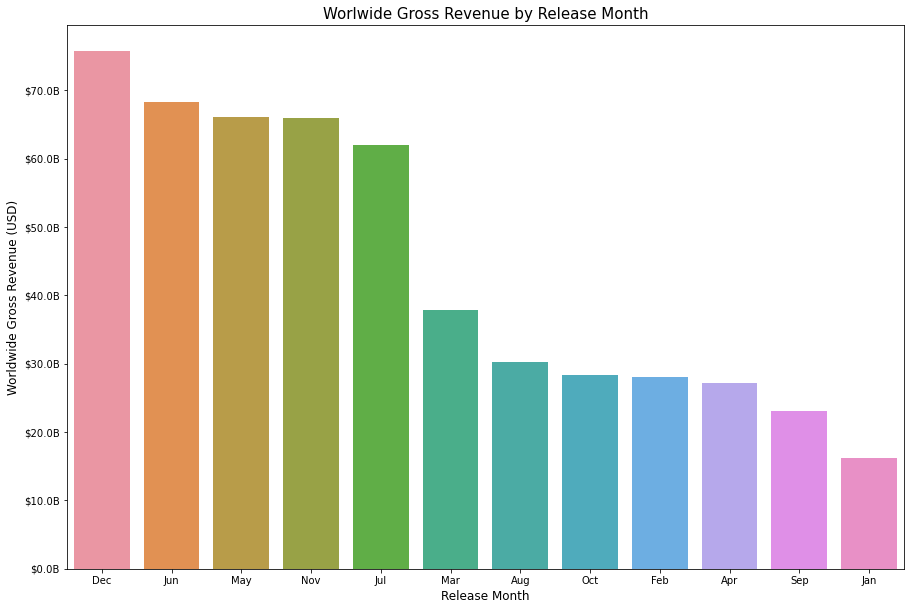

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=month_by["release_month"],y=month_by["worldwide_gross"],ax=ax)
ax.set_xlabel("Release Month", size = 12 )
ax.set_ylabel("Worldwide Gross Revenue (USD)", size = 12)
ax.set_title("Worlwide Gross Revenue by Release Month", size = 15)
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fB' % (x * 1e-9))
ax.yaxis.set_major_formatter(formatter);

plt.savefig("Worlwide Gross Revenue by Release Month.jpg",format="jpg")

# Visual of Production Budgets for Foreign and Domestic markets and how they perform respectively.
## Notice the inflection point that occurs at about $18.5M

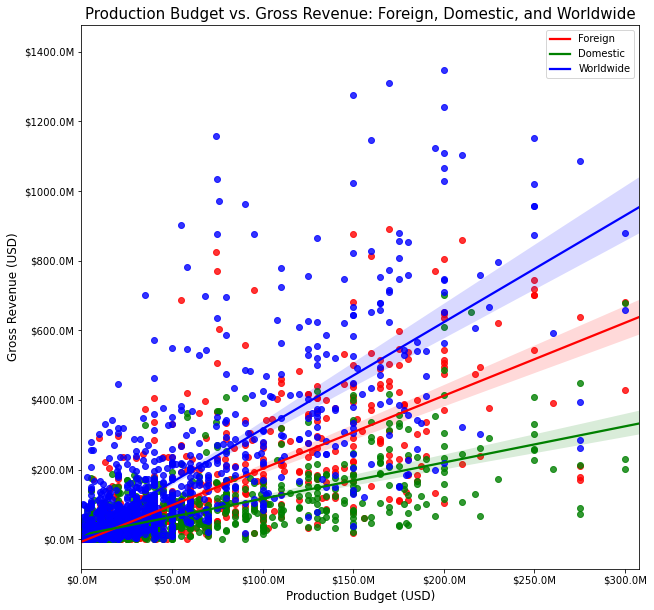

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.regplot(x=mov_clean["production_budget_clean"],y=mov_clean["foreign_gross"],color="red")
sns.regplot(x=mov_clean["production_budget_clean"],y=mov_clean["domestic_gross_y"],color="green")
sns.regplot(x=mov_clean["production_budget_clean"],y=mov_clean["worldwide_gross_int"],color="blue")
ax.set_xlabel("Production Budget (USD)", size = 12 )
ax.set_ylabel("Gross Revenue (USD)", size = 12)
ax.set_title("Production Budget vs. Gross Revenue: Foreign, Domestic, and Worldwide", size = 15)
ax.set_xlim(0,mov_clean["production_budget_clean"].max()*.75)
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fM' % (x * 1e-6))
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)
plt.legend(labels=["Foreign","Domestic","Worldwide"]);

plt.savefig("Production Budget vs. Gross Revenue: Foreign, Domestic, and Worldwide.jpg",format="jpg")

In [38]:
# Sort by gross revenue
sorted_df = grouped.sort_values(by="worldwide_gross_int",ascending=False)

# Visual to display the sum of Gross revenue per Movie Genre

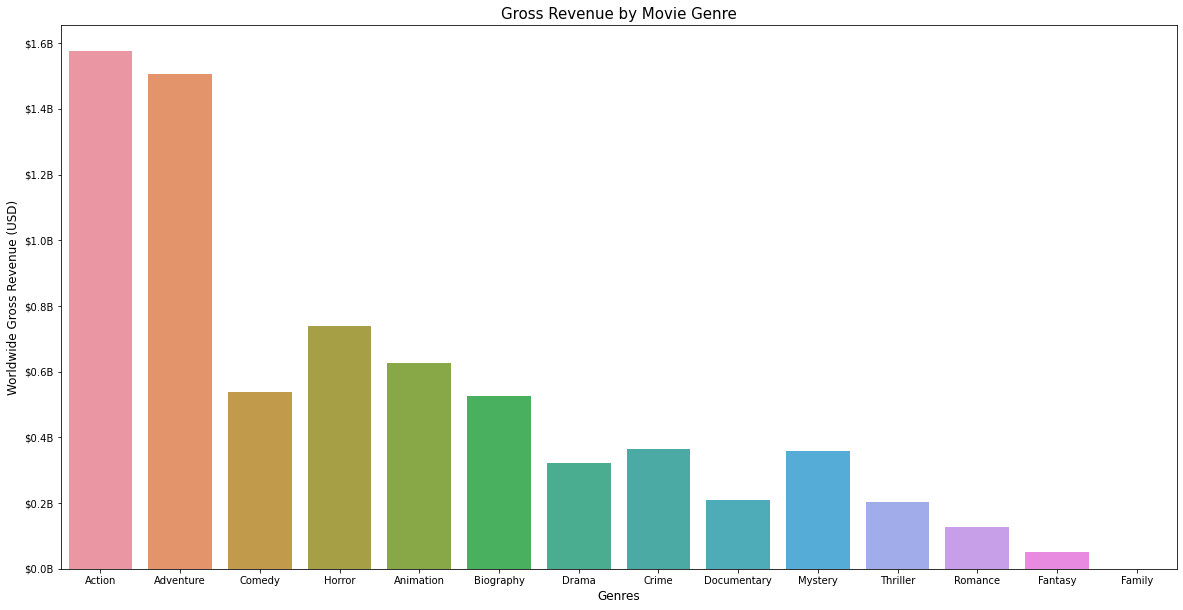

In [39]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=sorted_df["genres_clean"],y=sorted_df["worldwide_gross_int"], ci=None)
ax.set_xlabel("Genres", size = 12 )
ax.set_ylabel("Worldwide Gross Revenue (USD)", size = 12)
ax.set_title("Gross Revenue by Movie Genre", size = 15)
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fB' % (x * 1e-9))
ax.yaxis.set_major_formatter(formatter);

plt.savefig("Gross Revenue by Movie Genre.jpg",format="jpg")

# Show the distribution of Runtime for Movies

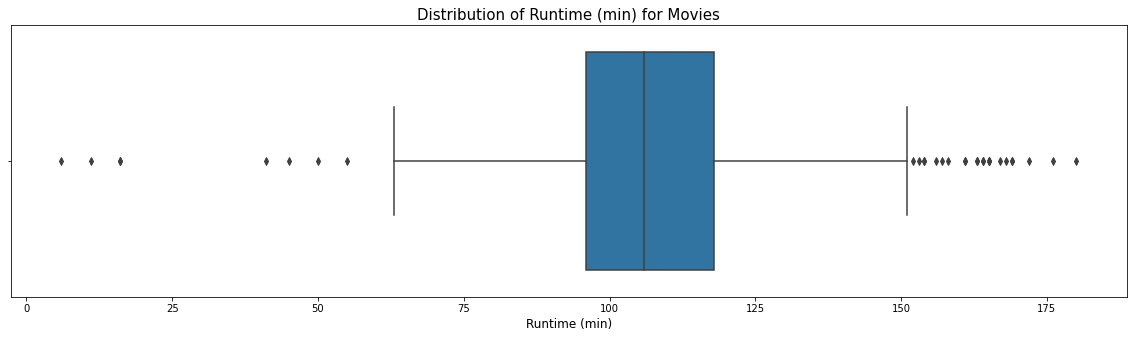

In [40]:
fig, ax = plt.subplots(figsize=(20, 5))

sns.boxplot(x=mov_clean["runtime_minutes_y"],ax=ax)
ax.set_xlabel("Runtime (min)", size = 12 )
ax.set_title("Distribution of Runtime (min) for Movies", size = 15);

plt.savefig("Distribution of Runtime (min) for Movies.jpg",format="jpg")

In [41]:
# Grouping by genres and runtime and summing the values to show gross worldwide revenue for each bucket
run_gen = mov_clean.groupby(["runtime_minutes_y","genres_y"]).sum().sort_values(by="worldwide_gross_int",ascending=False)
run_gen.reset_index(inplace=True)

In [42]:
# Cleaning genres to show only the first relevant category in a new column
genres_clean = []
for i in run_gen["genres_y"]:
    temp = []
    first = i.split(",")
    temp.append(first[0])
    genres_clean.append(temp[0])


run_gen["Genres"] = genres_clean

In [43]:
# Find how many unique Genres there are which need to be mapped with colors
hues = run_gen["Genres"].values.tolist()
len(run_gen["Genres"].unique())

13

In [44]:
# Create color map
colors = ['blue','red','#bcbcbc', '#bcbcbc', '#bcbcbc', '#bcbcbc', '#bcbcbc', '#bcbcbc', '#bcbcbc', '#bcbcbc', '#bcbcbc', '#bcbcbc', '#bcbcbc']

# Visual for Action and Adventure movies within a Runtime of 60-180 minutes. 
## Outliers are excluded with axis limits to enhance visualization.

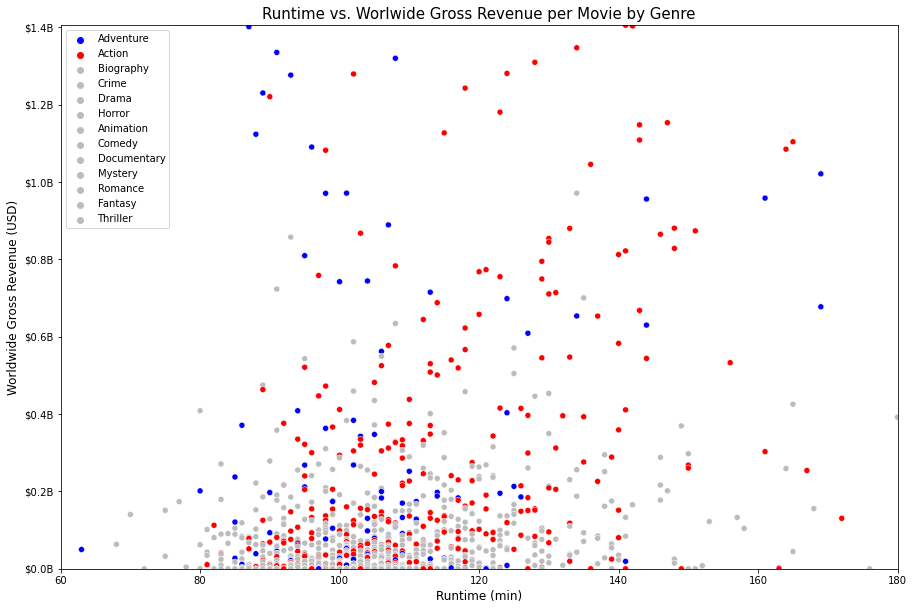

In [45]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x=run_gen["runtime_minutes_y"], y=run_gen["worldwide_gross_int"], hue=hues, palette=colors, ax=ax)
ax.set_xlabel("Runtime (min)", size = 12 )
ax.set_ylabel("Worldwide Gross Revenue (USD)", size = 12)
ax.set_title("Runtime vs. Worlwide Gross Revenue per Movie by Genre", size = 15)
ax.set_ylim(0,mov_clean["worldwide_gross_int"].max())
ax.set_xlim(60,mov_clean["runtime_minutes_y"].max())
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fB' % (x * 1e-9))
ax.yaxis.set_major_formatter(formatter);

plt.savefig("Runtime vs. Worlwide Gross Revenue per Movie by Genre.jpg",format="jpg")

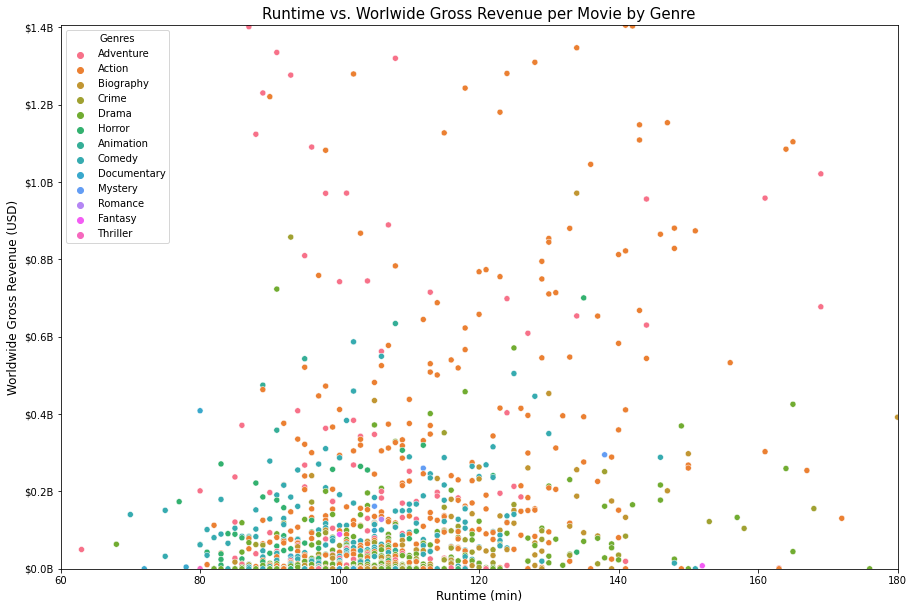

In [46]:
# Same as above, all genres have colors here
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x=run_gen["runtime_minutes_y"], y=run_gen["worldwide_gross_int"], hue = run_gen["Genres"],ax=ax)
ax.set_xlabel("Runtime (min)", size = 12 )
ax.set_ylabel("Worldwide Gross Revenue (USD)", size = 12)
ax.set_title("Runtime vs. Worlwide Gross Revenue per Movie by Genre", size = 15)
ax.set_ylim(0,mov_clean["worldwide_gross_int"].max())
ax.set_xlim(60,mov_clean["runtime_minutes_y"].max())
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fB' % (x * 1e-9))
ax.yaxis.set_major_formatter(formatter);

plt.savefig("Runtime vs. Worlwide Gross Revenue per Movie by Genre.jpg",format="jpg")